In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.1 MB/s eta 0:00:00
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
disease_types = 'tuberculosis','cancer'
path = Path('disease')

In [4]:
# Check whether a derictory 'path' is specified
if not path.exists():
    # If the 'path' does not exists path.mkdir creates directory where all images will be stored
    path.mkdir()
    for o in disease_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} lungs X-RAY')
        download_images(dest, urls=results, max_pics=1000)

In [5]:
fns = get_image_files(path)
fns

(#339) [Path('disease/tuberculosis/9c39c6be-84b0-4981-afe4-e114e13be440.jpg'),Path('disease/tuberculosis/13260967-b874-4d66-8643-939551f9e767.jpg'),Path('disease/tuberculosis/82f7bf07-e92a-4023-83d3-843bbf5c8dc9.png'),Path('disease/tuberculosis/a8a3e45f-5705-4d60-a8ae-71f8e551be8f.jpeg'),Path('disease/tuberculosis/7f8abf87-ec80-4906-ac8c-b954585eb364.jpg'),Path('disease/tuberculosis/08554e66-580c-4008-88c2-034aa60d622b.jpg'),Path('disease/tuberculosis/57e9c3c5-a296-4ec7-8668-07240cd43569.jpg'),Path('disease/tuberculosis/240bbd4d-04e2-447f-8af0-6e3711d840fa.jpg'),Path('disease/tuberculosis/651703db-a35e-40c6-835d-55d2ab086551.jpg'),Path('disease/tuberculosis/35e45d94-63c2-49a4-8b83-4d417dd9aafe.jpg')...]

Let's check corrupted files

In [6]:
failed = verify_images(fns)
failed

(#5) [Path('disease/tuberculosis/7054f0fb-fe59-4979-8470-7a5abd52aa1e.jpg'),Path('disease/cancer/c6a40a56-7ea0-4451-8e9b-11512c823afa.jpg'),Path('disease/cancer/de7f4e3a-477d-4cca-bfc0-1bb419557bae.svg'),Path('disease/cancer/70c5492a-323b-41d2-9ff0-06d1926d3c70.jpg'),Path('disease/cancer/14bfb667-8c4e-46e6-9a3a-1e48f3ff6f8a.jpg')]

To remove the failed images, we can use __unlink__ on each of them.

In [7]:
failed.map(Path.unlink)

(#5) [None,None,None,None,None]

In [10]:
diseases = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed = 12),
    get_y = parent_label,
    item_tfms = Resize(128)
)

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


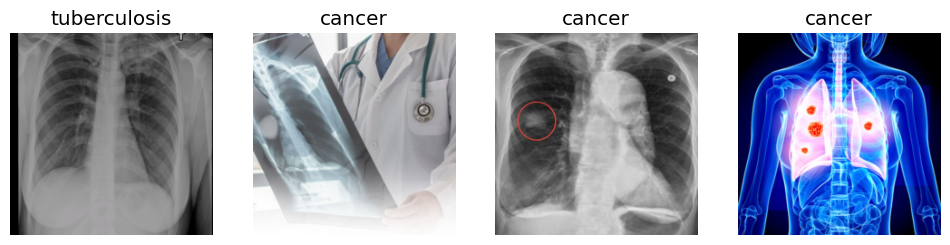

In [11]:
diseases = diseases.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms = aug_transforms())
dls = diseases.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [12]:
learn = vision_learner(dls, resnet18, metrics = error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 66.4MB/s]


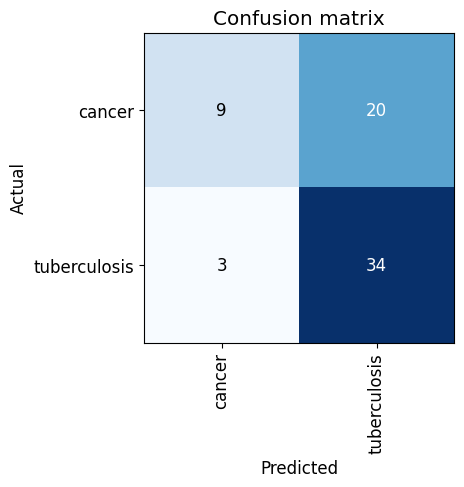

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

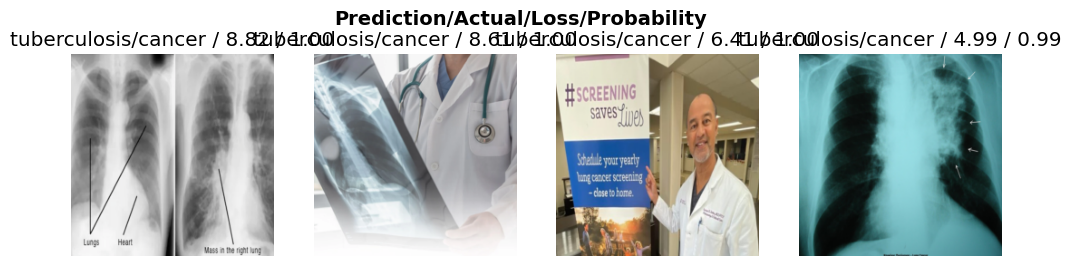

In [14]:
interp.plot_top_losses(4, nrows=1)

In [15]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [16]:
# To delete all images selected for deletion
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

# To move inages for which we selected a different category
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)